In [34]:
import os, json, sqlite3
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langchain_tavily import TavilySearch
from typing import TypedDict, Annotated, Literal, List
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage, BaseMessage, AIMessageChunk
from IPython.display import Image, Markdown
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv

_ = load_dotenv()  # take environment variables from .env.

In [2]:
search = TavilySearch()
llm = ChatGroq(model="openai/gpt-oss-120b", temperature=0)

In [3]:
@tool
def search_tool(query: str) -> str:
    """
    Search the web for information using Tavily API.

    :param query: The search query string
    :return: Search results related to the query
    """
    
    return search.invoke(query)

In [4]:
tools = [search_tool]
llm_with_tools = llm.bind_tools(tools)

In [5]:
class ChatState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]

In [6]:
def chat_node(state: ChatState):
    """LLM node that may answer or request a tool call."""
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

In [7]:
checkpoint = MemorySaver()

In [35]:
os.makedirs("database", exist_ok=True)
if not os.path.exists(os.path.join("database", "chat_history.db")):
    conn = sqlite3.connect(os.path.join("database", "chat_history.db"), check_same_thread=False)
else:
    conn = sqlite3.connect(os.path.join("database", "chat_history.db"), check_same_thread=False)

checkpointer = SqliteSaver(conn=conn)

In [36]:
graph = StateGraph(ChatState)

graph.add_node("chat_node", chat_node)
graph.add_node("tools", ToolNode(tools))

graph.add_edge(START, "chat_node")
graph.add_conditional_edges("chat_node", tools_condition)
graph.add_edge("tools", "chat_node")

workflow = graph.compile(checkpointer=checkpointer)

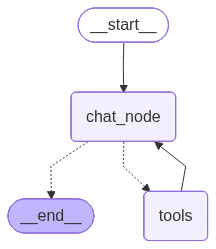

In [37]:
workflow

In [38]:
config = { 'configurable': { 'thread_id': '1' } }
initial_state = { "messages": [HumanMessage(content="what is the weather of karachi?")] }
final_state = workflow.invoke(initial_state, config=config)

In [39]:
Markdown(final_state["messages"][-1].content)

**Current weather in Karachi (as of 19:00 local time on 1 Oct 2025)**  

| Parameter | Value |
|-----------|-------|
| **Temperature** | **31 °C** (87.8 °F) |
| **Feels like** | 34 °C (93.5 °F) |
| **Condition** | Partly cloudy |
| **Wind** | 9.2 mph (14.8 kph) from the east (97°) |
| **Humidity** | 59 % |
| **Pressure** | 1001 mb (29.56 in) |
| **Precipitation** | 0 mm (0 in) – no rain at the moment |
| **Cloud cover** | 50 % |
| **Visibility** | 6 km (3 mi) |
| **UV index** | 0 (nighttime) |
| **Sunrise / Sunset** | (approx.) 05:45 am / 06:15 pm local time |

**What this means**

- It’s a warm night, with temperatures in the low‑30 °C range.  
- The “feels‑like” temperature is a few degrees higher because of the humidity and light wind.  
- The sky is partly cloudy, but there’s no rain right now and the chance of precipitation is low for the next few hours.  
- Winds are gentle from the east, so you won’t feel much breeze.  

If you’re planning to be outdoors tonight, dress for warm weather (light clothing) and consider a light jacket if you’re sensitive to the night‑time chill. The conditions should stay fairly stable through the night, with no significant rain expected.

In [19]:
chunk =workflow.stream(initial_state, config=config, stream_mode="messages")

In [31]:
# Streaming function for LLM response only
def ai_only_stream(user_input: str):
    for message_chunk, metadata in workflow.stream(
        {"messages": [HumanMessage(content=user_input)]},
        config=config,
        stream_mode="messages"
    ):
        if isinstance(message_chunk, AIMessageChunk):
            # Yield only non-empty LLM response content, excluding tool calls
            if message_chunk.content and not message_chunk.additional_kwargs.get('tool_calls'):
                yield message_chunk.content

# Run the streaming function
user_input = "what is the weather of karachi?"
print("Starting stream...\n")
for chunk in ai_only_stream(user_input):
    print(chunk, end='', flush=True)  # Print in real-time
print("\n\nStream complete.")

Starting stream...

**Karachi – Current Weather (2025‑10‑01, 18:00 local time)**  

- **Temperature:** 32.2 °C (90 °F)  
- **Feels like:** 36.3 °C (97 °F)  
- **Condition:** Partly cloudy  
- **Wind:** 16 km/h (10 mph) from the east (≈ 82°)  
- **Humidity:** 52 %  
- **Pressure:** 1000 mb (29.5 inHg)  
- **Precipitation:** 0 mm (no rain)  
- **UV index:** 0.1 (very low)  
- **Visibility:** 6 km (3 mi)  

*Source: WeatherAPI.com (real‑time data for Karachi, Pakistan).*

Stream complete.
